In [5]:
import pandas as pd
from aeon.visualisation import plot_critical_difference

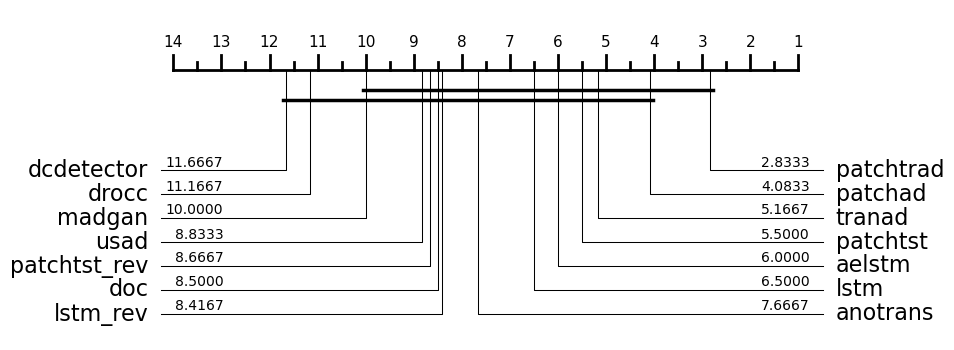

In [6]:
results = pd.read_json("results/aucs.json")

#####
# to delete bc drocc on smd not implemented yet
results.loc['drocc', 'smd'] = 0.5
results = results.T
#####

methods = results.columns
plot = plot_critical_difference(results.values, methods, alpha=0.05, width=8, test='nemenyi')  

In [9]:
results = results.round(3).T
results["mean"] = results.mean(axis=1).round(3)
results

,nyc_taxi,ec2_request_latency_system_failure,msl,swat,smap,smd,mean
aelstm,0.664,0.998,0.589,0.840,0.614,0.828,0.756
anotrans,0.491,0.994,0.609,0.819,0.637,0.678,0.705
patchtst,0.696,0.999,0.560,0.843,0.514,0.882,0.749
usad,0.675,0.977,0.622,0.814,0.448,0.638,0.696
lstm,0.511,0.999,0.582,0.842,0.604,0.833,0.728
tranad,0.551,0.967,0.622,0.815,0.668,0.884,0.751
patchtrad,0.922,0.999,0.622,0.845,0.629,0.869,0.814
patchad,0.972,0.998,0.625,0.822,0.630,0.818,0.811
madgan,0.782,0.011,0.499,0.791,0.544,0.708,0.556
drocc,0.529,0.886,0.531,0.751,0.569,0.500,0.628
